# Pseudomonas

Fig 3 for the paper.

## Set up and reading the data

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib


In [2]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


In [3]:
outdir = 'pseudomonas'
os.makedirs(outdir, exist_ok=True)
imagedir = 'final_images'
os.makedirs(imagedir, exist_ok=True)

### Read the autoencoder

In [4]:
encoder_models = 'cluster_gbrfs'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['COPF', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['COPF'] = cluster_assignments['COPF'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

## Run the Gradient Boosted Random Forest

The data for the classifier is {'no': 91, 'yes': 36} variables
We used 349 estimators for the random forest classifier
Mean squared error for CS_Pseudomonas aeruginosa using classifier is 0.19230769230769232


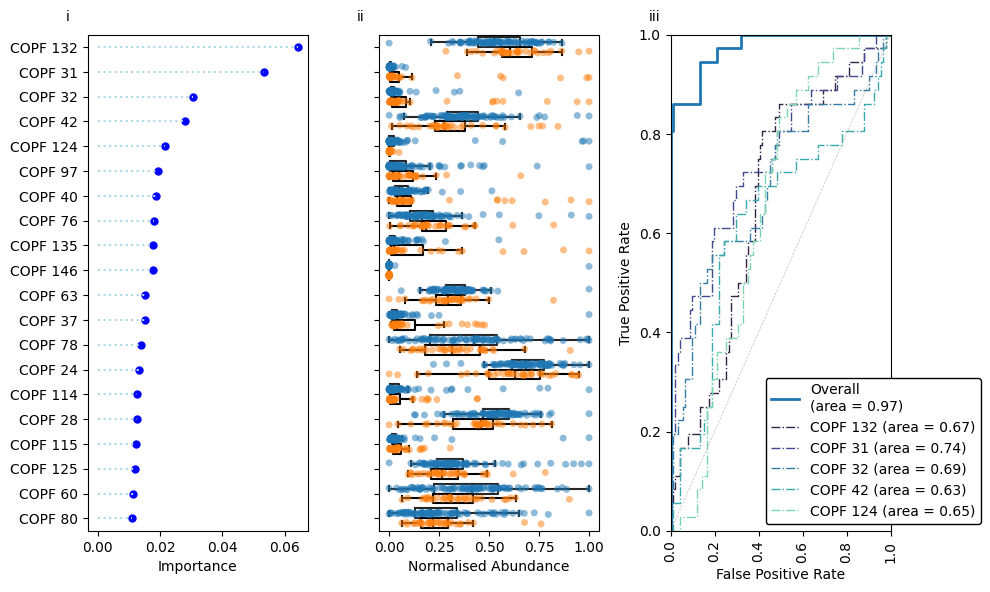

In [5]:
intcol = 'CS_Pseudomonas aeruginosa'

intcol_title = ""
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
fig, axes = cf_analysis_lib.plot_importance_abundance_roc(merged_df, feature_importances_sorted, intcol, intcol_title, model,
                                     custom_labels, plot_legend=False)

labels = [cf_analysis_lib.int2roman(i+1) for i in range(3)] # this makes the labels roman numerals
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, va='top', ha='left')
    ax.set_title("")
print()

plt.tight_layout()
plt.savefig('final_images/fig3a.png')
plt.show()

## _Pseudomonas_ and MAGs

How does the abundance of Pseudomonas reflect the MAGs

In [6]:
mags = cf_analysis_lib.read_mag_coverage()
mags.head()

,mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9,mag_10,...,mag_65224,mag_66866,mag_68519,mag_68728,mag_70256,mag_70473,mag_72938,mag_75531,mag_77836,mag_82829
Sample,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,0.00726,0.01027,0.24020,0.06601,0.002813,0.058595,0.05947,0.00000,0.1469,0.07295,...,5.668,11.350,0.9917,5.0065,0.47575,5.563,17.460,0.5397,5.434,17.98000
1447437_20171212_S,0.00000,0.11850,0.15450,1.39500,0.053300,0.294500,0.00000,0.09932,0.2610,0.15570,...,7.293,7.901,0.7893,5.8950,1.23240,5.293,11.820,1.1090,3.157,0.37425
1128691_20171206_S,0.00000,15.26000,0.00000,0.00000,0.000000,0.000000,4.26900,0.00000,0.1558,0.00000,...,0.000,5.522,0.0000,7.7310,0.00000,0.000,9.730,0.0000,4.969,0.00000
1128691_20171218_S,0.00000,6.09000,0.89995,0.46680,0.000000,0.000000,0.00000,0.00000,1.4430,0.00000,...,8.985,3.609,0.0000,2.0625,0.00000,0.000,8.824,0.0000,8.296,0.00000
1128691_20180116_S,0.00000,20.17000,0.00000,0.89365,0.000000,29.395000,1.74900,0.00000,0.0000,0.00000,...,0.000,0.000,0.0000,0.0000,0.00000,0.000,9.599,0.0000,0.000,0.00000


In [7]:
mag_metadata = cf_analysis_lib.read_mag_metadata()
mag_metadata.head()

,MAG,CheckM,UID,# genomes,# markers,# marker sets,0,1,2,3,4,5+,Completeness,Contamination,Strain heterogeneity,BV-BRC Mash,contigs,total size,BV-BRC Protein,GTDB
Bin Id,,,,,,,,,,,,,,,,,,,,
1,mag_1,k__Bacteria,(UID203),5449,104,58,28,30,31,14,1,0,62.27,31.07,3.8,Unknown,299,12081483,Mycobacterium,Njordarchaeia
2,mag_2,o__Burkholderiales,(UID4000),193,427,214,2,421,4,0,0,0,99.44,0.99,0.0,Achromobacter,123,6910862,Pseudomonas,Achromobacter
3,mag_3,o__Actinomycetales,(UID1809),267,400,222,2,386,12,0,0,0,99.40,1.63,50.0,Corynebacterium,48,2019611,Corynebacterium,Corynebacterium
4,mag_4,g__Staphylococcus,(UID298),56,805,176,26,754,25,0,0,0,98.71,1.28,36.0,Staphylococcus,136,2646744,Staphylococcus,Staphylococcus
5,mag_5,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,5,220351,Unclassified Bacteria,NaN


In [8]:
# which MAGs are Pseudomonas?
cols = ['CheckM', 'BV-BRC Mash', 'BV-BRC Protein', 'GTDB']
mag_metadata['pseudomonas'] = (
    mag_metadata[cols].apply(lambda x: x.str.lower().str.contains('pseudomona', na=False)).any(axis=1)
)
mag_metadata[mag_metadata['pseudomonas']]

,MAG,CheckM,UID,# genomes,# markers,# marker sets,0,1,2,3,...,5+,Completeness,Contamination,Strain heterogeneity,BV-BRC Mash,contigs,total size,BV-BRC Protein,GTDB,pseudomonas
Bin Id,,,,,,,,,,,,,,,,,,,,,
2,mag_2,o__Burkholderiales,(UID4000),193,427,214,2,421,4,0,...,0,99.44,0.99,0.00,Achromobacter,123,6910862,Pseudomonas,Achromobacter,True
12,mag_12,o__Pseudomonadales,(UID4488),185,813,308,4,800,8,1,...,0,99.27,1.60,72.73,Pseudomonas,406,6428243,Pseudomonas,Pseudomonas,True
48,mag_48,root,(UID1),5656,56,24,56,0,0,0,...,0,0.00,0.00,0.00,Unknown,1,32516,Pseudomonas,Unclassified,True
109,mag_109,root,(UID1),5656,56,24,56,0,0,0,...,0,0.00,0.00,0.00,Unknown,2,34897,Pseudomonas,Pseudomonas,True
118,mag_118,root,(UID1),5656,56,24,56,0,0,0,...,0,0.00,0.00,0.00,Unknown,9,68509,Pseudomonas,Unclassified,True
129,mag_129,root,(UID1),5656,56,24,56,0,0,0,...,0,0.00,0.00,0.00,Unknown,2,24799,Pseudomonas,Pseudomonas,True
135,mag_135,root,(UID1),5656,56,24,56,0,0,0,...,0,0.00,0.00,0.00,Achromobacter,601,2065868,Pseudomonas,Unclassified Bacteria,True
167,mag_167,root,(UID1),5656,56,24,56,0,0,0,...,0,0.00,0.00,0.00,Unknown,3,27960,Pseudomonas,Pseudomonas,True
303,mag_303,root,(UID1),5656,56,24,56,0,0,0,...,0,0.00,0.00,0.00,Unknown,12,90121,Pseudomonas,Unclassified,True


# Create a volcano plot of the MAGs

Here, we make a volcano plot of the MAGs and their abundance in the samples

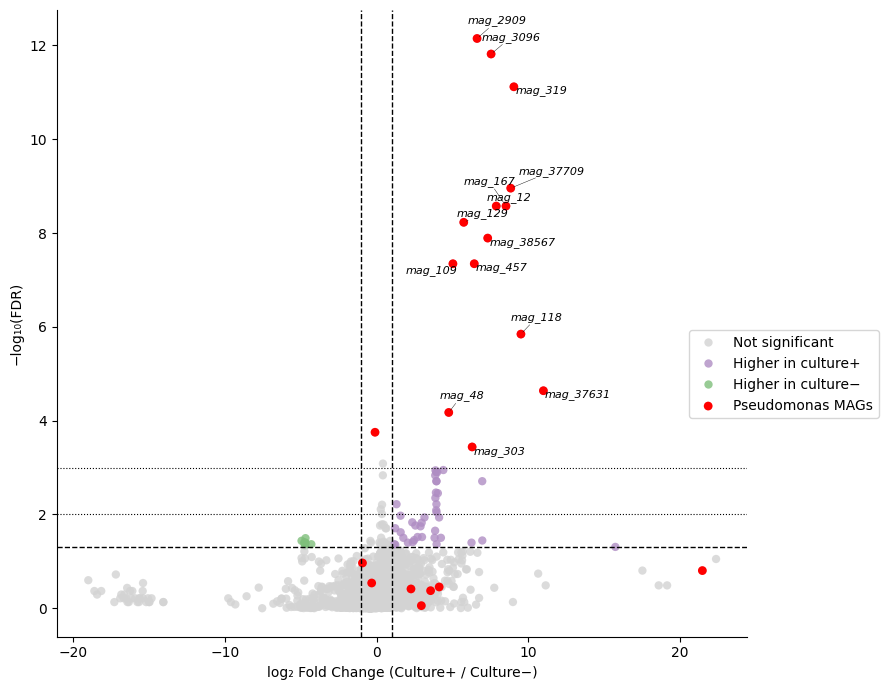

In [9]:
intcol = 'CS_Pseudomonas aeruginosa'
mag_plus_meta = mags.join(metadata[[intcol]]).dropna(subset=intcol)
mag_cols = mag_plus_meta.columns[:-1]   # all MAGs

results = []
for mag in mags:
    group0 = mag_plus_meta.loc[mag_plus_meta[intcol] == 0, mag]
    group1 = mag_plus_meta.loc[mag_plus_meta[intcol] == 1, mag]

    if len(group0) < 3 or len(group1) < 3:
        continue

    # Avoid divide-by-zero and heavy tails
    fc = (group1.mean() + 1e-6) / (group0.mean() + 1e-6)
    log2_fc = np.log2(fc)

    # Non-parametric test
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    results.append({'MAG': mag, 'log2FC': log2_fc, 'pval': p})

# Create DataFrame
volcano_df = pd.DataFrame(results)

# Adjust p-values using Benjamini-Hochberg
rejected, fdr_pvals = fdrcorrection(volcano_df['pval'])
volcano_df['FDR'] = fdr_pvals
volcano_df['-log10(FDR)'] = -np.log10(volcano_df['FDR'])

# Significance thresholds
fc_thresh = 1.0    # log2 fold-change
fdr_thresh = 0.05  # adjusted p-value
extra_fdr_lines = [0.01, 0.001]

volcano_df['Significance'] = 'Not significant'
volcano_df.loc[
    (volcano_df['log2FC'] > fc_thresh) & (volcano_df['FDR'] < fdr_thresh),
    'Significance'
] = 'Higher in culture+'
volcano_df.loc[
    (volcano_df['log2FC'] < -fc_thresh) & (volcano_df['FDR'] < fdr_thresh),
    'Significance'
] = 'Higher in culture−'

# add the columns that are pseudomonas from mag_metadata
volcano_df = volcano_df.merge(
    mag_metadata[['MAG', 'pseudomonas']],
    on='MAG',
    how='left'
)
volcano_df['pseudomonas'] = volcano_df['pseudomonas'].fillna(0).astype(bool)

# Sort by significance and take top 10 for labelling
"""
top_hits = (
    volcano_df[volcano_df['FDR'] < fdr_thresh]
    .sort_values('FDR')
    .head(14)
)
"""
# this top hits is limited to the significant ones above the FDR line!
top_hits = volcano_df[(volcano_df['FDR'] < fdr_thresh) & (volcano_df['Significance'] != 'Not significant') & (volcano_df['-log10(FDR)'] > -np.log10(extra_fdr_lines[1]))]

# --- Plot ---
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=volcano_df,
    x='log2FC',
    y='-log10(FDR)',
    hue='Significance',
    palette={
        'Not significant': 'lightgrey',
        'Higher in culture+': '#af8dc3',  # previously: '#D55E00',
        'Higher in culture−': '#7fbf7b', # previouslty: '#0072B2'
    },
    alpha=0.8,
    edgecolor='none'
)

sns.scatterplot(
    data=volcano_df[volcano_df['pseudomonas']],
    x='log2FC',
    y='-log10(FDR)',
    color='red',
    s=40,
    edgecolor='none',
    label='Pseudomonas MAGs'
)


# Highlight thresholds
plt.axhline(-np.log10(fdr_thresh), color='black', linestyle='--', lw=1)
plt.axvline(fc_thresh, color='black', linestyle='--', lw=1)
plt.axvline(-fc_thresh, color='black', linestyle='--', lw=1)
for f in extra_fdr_lines:
    plt.axhline(-np.log10(f), color='black', ls=':', lw=0.8)
    
# Label top hits
texts = []
for _, r in top_hits.iterrows():
    texts.append(plt.text(
        r['log2FC'],
        r['-log10(FDR)'],
        r['MAG'],
        fontsize=8,
        ha='center',
        va='bottom',
        fontstyle='italic',
        color='black'
    ))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.3))
# Polish
# plt.title('Volcano plot of MAG abundance vs Pseudomonas culture status', fontsize=14, weight='bold')
plt.xlabel('log₂ Fold Change (Culture+ / Culture−)', fontsize=10)
plt.ylabel('−log₁₀(FDR)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='', bbox_to_anchor=(1.2, 0.5), fontsize=10)
sns.despine()
plt.tight_layout()
plt.savefig('final_images/fig4.png', dpi=300)
plt.show()


In [10]:
thmags = mag_metadata[mag_metadata['MAG'].isin(top_hits['MAG'])].reset_index()[['MAG', 'total size']]
thmags.sort_values(by='total size')

,MAG,total size
4,mag_129,24799
5,mag_167,27960
8,mag_457,32472
1,mag_48,32516
11,mag_37631,32921
2,mag_109,34897
10,mag_3096,41014
13,mag_38567,44261
9,mag_2909,47830
3,mag_118,68509


In [11]:
thmags['total size'].mean()

506222.14285714284

# MDR Peudomonas

The MDR Pseudomonas is a subset of the Pseudomonas - all the entries for MDR culturing also have regular Pseudomonas, so what makes them different?

In [12]:
metadata[metadata['CS_Pseudomonas aeruginosa'] == 1][['CS_Pseudomonas aeruginosa', 'CS_MDR_Pseudomonas aeruginosa']].groupby('CS_MDR_Pseudomonas aeruginosa').count()

,CS_Pseudomonas aeruginosa
CS_MDR_Pseudomonas aeruginosa,
0,22
1,14


'CS_MDR_Pseudomonas aeruginosa' has samples from 14 pwCF


The data for the classifier is {'no': 22, 'yes': 14} variables
We used 189 estimators for the random forest classifier
Mean squared error for CS_MDR_Pseudomonas aeruginosa using classifier is 0.5


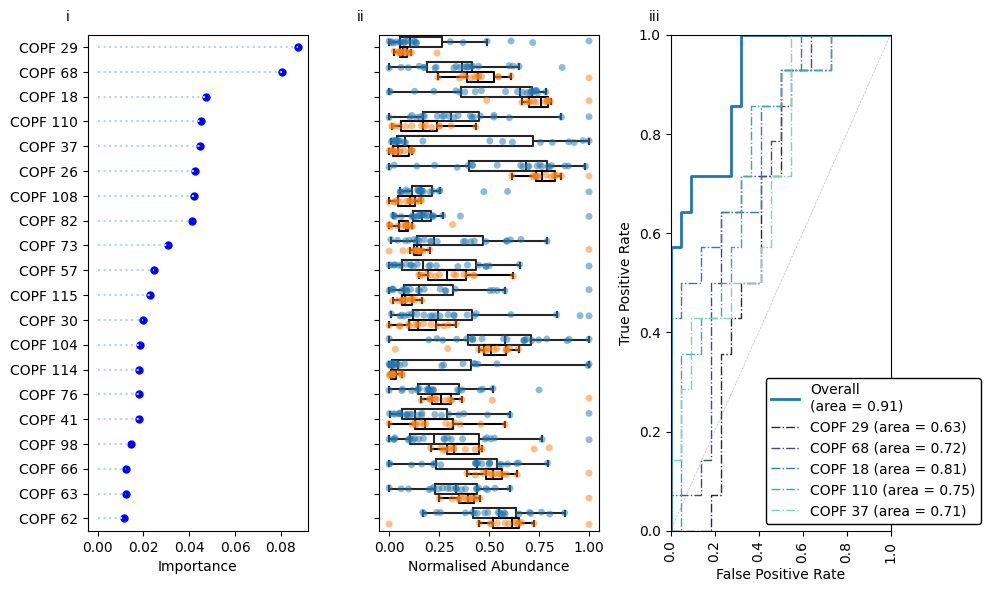

In [13]:
intcol = 'CS_MDR_Pseudomonas aeruginosa'
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

# set up our titles and the filename
#intcol_title = replace_index.sub('', intcol)
intcol_title = ""
intcol_filename = intcol.replace(" ", "_")

# we limit this to only those samples that ALSO have Pseudomonas, so now we can see if any clusters discriminate regular from MDR Pseudomonas.
merged_df = pc_df.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 1][intcol], how='inner').dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
if categorical_data is None:
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
fig, axes = cf_analysis_lib.plot_importance_abundance_roc(merged_df, feature_importances_sorted, intcol, intcol_title, model,
                                     custom_labels, plot_legend=False)

labels = [cf_analysis_lib.int2roman(i+1) for i in range(3)] # this makes the labels roman numerals
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, va='top', ha='left')
    ax.set_title("")
print()
plt.tight_layout()
plt.savefig('final_images/fig3b.png')
plt.show()

## Volcano plot for MDR Pseudomonas

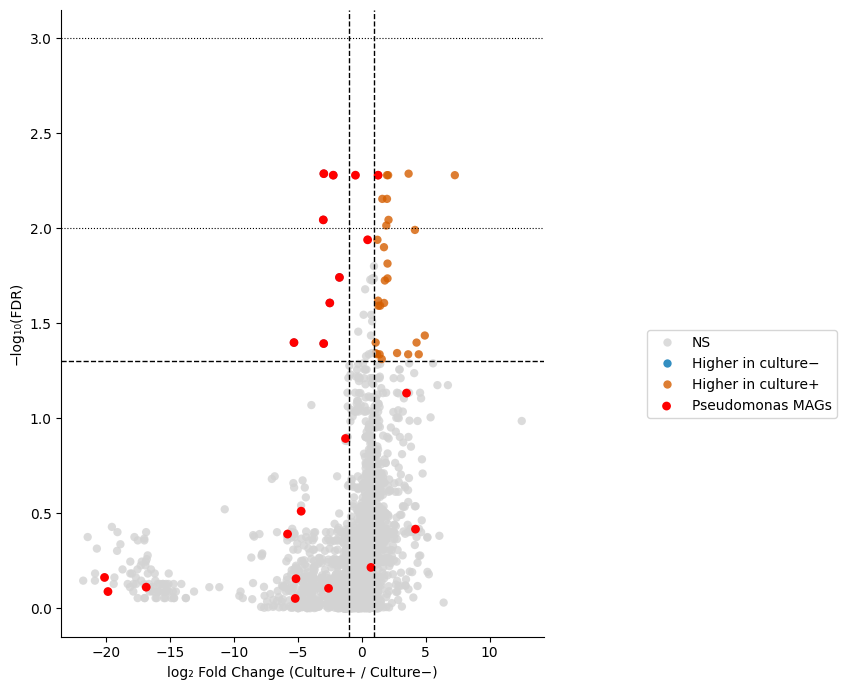

In [14]:
intcol = 'CS_MDR_Pseudomonas aeruginosa'
mag_plus_meta = mags.join(metadata[[intcol]]).dropna(subset=intcol)
mag_cols = mag_plus_meta.columns[:-1]   # all MAGs

results = []
for mag in mags:
    group0 = mag_plus_meta.loc[mag_plus_meta[intcol] == 0, mag]
    group1 = mag_plus_meta.loc[mag_plus_meta[intcol] == 1, mag]

    if len(group0) < 3 or len(group1) < 3:
        continue

    # Avoid divide-by-zero and heavy tails
    fc = (group1.mean() + 1e-6) / (group0.mean() + 1e-6)
    log2_fc = np.log2(fc)

    # Non-parametric test
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    results.append({'MAG': mag, 'log2FC': log2_fc, 'pval': p})

# Create DataFrame
volcano_df = pd.DataFrame(results)

# Adjust p-values using Benjamini-Hochberg
rejected, fdr_pvals = fdrcorrection(volcano_df['pval'])
volcano_df['FDR'] = fdr_pvals
volcano_df['-log10(FDR)'] = -np.log10(volcano_df['FDR'])

# Significance thresholds
fc_thresh = 1.0    # log2 fold-change
fdr_thresh = 0.05  # adjusted p-value
extra_fdr_lines = [0.01, 0.001]

volcano_df['Significance'] = 'NS'
volcano_df.loc[
    (volcano_df['log2FC'] > fc_thresh) & (volcano_df['FDR'] < fdr_thresh),
    'Significance'
] = 'Higher in culture+'
volcano_df.loc[
    (volcano_df['log2FC'] < -fc_thresh) & (volcano_df['FDR'] < fdr_thresh),
    'Significance'
] = 'Higher in culture−'

# add the columns that are pseudomonas from mag_metadata
volcano_df = volcano_df.merge(
    mag_metadata[['MAG', 'pseudomonas']],
    on='MAG',
    how='left'
)
volcano_df['pseudomonas'] = volcano_df['pseudomonas'].fillna(0).astype(bool)

# Sort by significance and take top 10 for labelling
"""
top_hits = (
    volcano_df[volcano_df['FDR'] < fdr_thresh]
    .sort_values('FDR')
    .head(14)
)
"""
# this top hits is limited to the significant ones above the FDR line!
top_hits = volcano_df[(volcano_df['FDR'] < fdr_thresh) & (volcano_df['Significance'] != 'NS') & (volcano_df['-log10(FDR)'] > -np.log10(extra_fdr_lines[1]))]

# --- Plot ---
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=volcano_df,
    x='log2FC',
    y='-log10(FDR)',
    hue='Significance',
    palette={
        'NS': 'lightgrey',
        'Higher in culture+': '#D55E00',
        'Higher in culture−': '#0072B2'
    },
    alpha=0.8,
    edgecolor='none'
)

sns.scatterplot(
    data=volcano_df[volcano_df['pseudomonas']],
    x='log2FC',
    y='-log10(FDR)',
    color='red',
    s=40,
    edgecolor='none',
    label='Pseudomonas MAGs'
)


# Highlight thresholds
plt.axhline(-np.log10(fdr_thresh), color='black', linestyle='--', lw=1)
plt.axvline(fc_thresh, color='black', linestyle='--', lw=1)
plt.axvline(-fc_thresh, color='black', linestyle='--', lw=1)
for f in extra_fdr_lines:
    plt.axhline(-np.log10(f), color='black', ls=':', lw=0.8)
    
# Label top hits
texts = []
for _, r in top_hits.iterrows():
    texts.append(plt.text(
        r['log2FC'],
        r['-log10(FDR)'],
        r['MAG'],
        fontsize=8,
        ha='center',
        va='bottom',
        fontstyle='italic',
        color='black'
    ))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.3))
# Polish
# plt.title('Volcano plot of MAG abundance vs Pseudomonas culture status', fontsize=14, weight='bold')
plt.xlabel('log₂ Fold Change (Culture+ / Culture−)', fontsize=10)
plt.ylabel('−log₁₀(FDR)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='', bbox_to_anchor=(1.2, 0.5), fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()


In [30]:
cluster_assignments[cluster_assignments['COPF']==82]

,COPF,Feature
527,82,NADH ubiquinone oxidoreductase vs. multi-subun...
528,82,Menaquinone biosynthesis from chorismate via 1...


## Converting to Pseudomonas culturable state

We have 36 samples from pwCF who culture negative for Pseudomonas but convert in the next year. We have one sample from someone who was positive for Pseudomonas but was not positive a year later, but that is not enough to draw conclusions. However, we also have 38 samples from people who were culture negative for Pseudomonas and were also culture negative a year later.

Lets subset the data to people who are Pseudomonas negative, and then see if we can predict a driver towards positivity.

In [15]:
# pwCF who are positive but not later on
metadata[(metadata['CS_Pseudomonas aeruginosa'] == 1) & (metadata['N12M_Pseudomonas aeruginosa'] == 0)][['CS_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']]

,CS_Pseudomonas aeruginosa,N12M_Pseudomonas aeruginosa
NAME,,
715927_20180213_S,1,0.0


In [16]:
# pwCF who are Pseudo negative and then become positive.
metadata[(metadata['CS_Pseudomonas aeruginosa'] == 0) & (metadata['N12M_Pseudomonas aeruginosa'] == 1)][['CS_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']]

,CS_Pseudomonas aeruginosa,N12M_Pseudomonas aeruginosa
NAME,,
1068841_20180306_S,0,1.0
1586713_20180309_S,0,1.0
1590009_20171212_S,0,1.0
1651490_20171010_S,0,1.0
1651490_20171215_S,0,1.0
1651490_20180206_S,0,1.0
642660_20180601_S,0,1.0
650003_20180213_S,0,1.0
658355_20170925_S,0,1.0


In [17]:
pc_df

,COPF 1,COPF 2,COPF 3,COPF 4,COPF 5,COPF 6,COPF 7,COPF 8,COPF 9,COPF 10,...,COPF 141,COPF 142,COPF 143,COPF 144,COPF 145,COPF 146,COPF 147,COPF 148,COPF 149,COPF 150
1068841_20180306_S,276.176615,302.702198,1546.961129,1244.654020,97582.527423,4407.930069,1853.665398,715.507023,1638.820467,2314.236268,...,147.319228,-3.715643,-16.828942,-0.620425,-1391.234421,-1243.923904,-60.174780,-3438.957859,-31.329157,-147.293113
1447437_20171212_S,2705.663672,4690.862862,1661.627899,715.710503,-53458.096239,-392.542683,-1920.800676,-45.881704,-1404.573200,-1949.069093,...,-275.248829,-9.682479,-41.156992,-0.995247,-2240.140070,-1260.331553,-45.982448,-3971.187800,20.345835,-48.990355
1128691_20171206_S,-603.660074,-4577.510659,-4420.313788,-4958.557622,-195353.148806,-2374.194484,-1545.660627,-1725.120119,-3424.555171,-11010.612617,...,38.671835,-13.540291,14.266131,-1.015739,-3075.867772,-1213.717295,-77.174977,-3633.884812,-431.277056,-226.646071
1128691_20171218_S,-78.550058,-3104.503785,-3654.194165,-4454.618230,-173495.186399,-1922.264320,-1179.426731,-1548.680605,-3441.985162,-8616.698464,...,-98.707729,-13.540291,-45.479552,-1.015739,-2787.609881,-853.652167,-64.069528,-5121.928855,-250.796657,-341.952372
1128691_20180116_S,-1074.430518,-5052.322268,-5018.453689,-5474.994108,-215985.383039,-2426.518094,-1914.673485,-1949.175659,-3847.890163,-12551.371875,...,-76.610617,-13.540291,-45.068192,-1.015739,-3171.888089,-989.919971,-76.271303,-4705.279048,-397.884774,-371.751060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,400.288923,900.058161,-1016.027994,-970.041149,90351.749908,-1513.704455,-572.187928,8.526954,274.609764,-518.976032,...,58.990314,-7.311420,-1.255576,-1.068836,-1706.280443,-1258.491952,-58.988201,-3468.318984,336.712850,270.229166
896213_20180427_S,-987.386467,-686.446202,-1049.470879,-1568.508275,-42551.788144,2037.257278,-65.971431,79.719672,-52.559735,-2532.977561,...,-96.512542,12.686354,-4.258667,-1.965522,-627.714664,-1254.798853,-73.321593,-4013.291730,66.560372,-97.730236
913873_20180417_S,-761.521036,-446.796201,-160.302757,-852.755732,-1808.085607,3658.931376,-464.674844,-276.411538,-422.883787,1600.248043,...,209.381056,60.011847,-45.520979,54.562206,-292.270189,-1252.243469,873.912502,-3951.618096,187.499984,-414.887222
980574_20180403_S,-557.301890,135.000407,-522.286734,-236.762972,-2487.417301,-917.200466,-519.817611,-136.346160,-569.883346,-177.050005,...,122.158067,-7.041619,-11.163428,-0.800012,-1597.937366,-1239.243166,-44.131363,-3254.765058,-12.354979,1272.006312


'N12M_Pseudomonas aeruginosa' has samples from 71 pwCF


We dropped some rows, so our data has shape (74, 151)
The data for the classifier is {'no': 38, 'yes': 36} variables
We used 23 estimators for the random forest classifier
Mean squared error for N12M_Pseudomonas aeruginosa using classifier is 0.6666666666666666


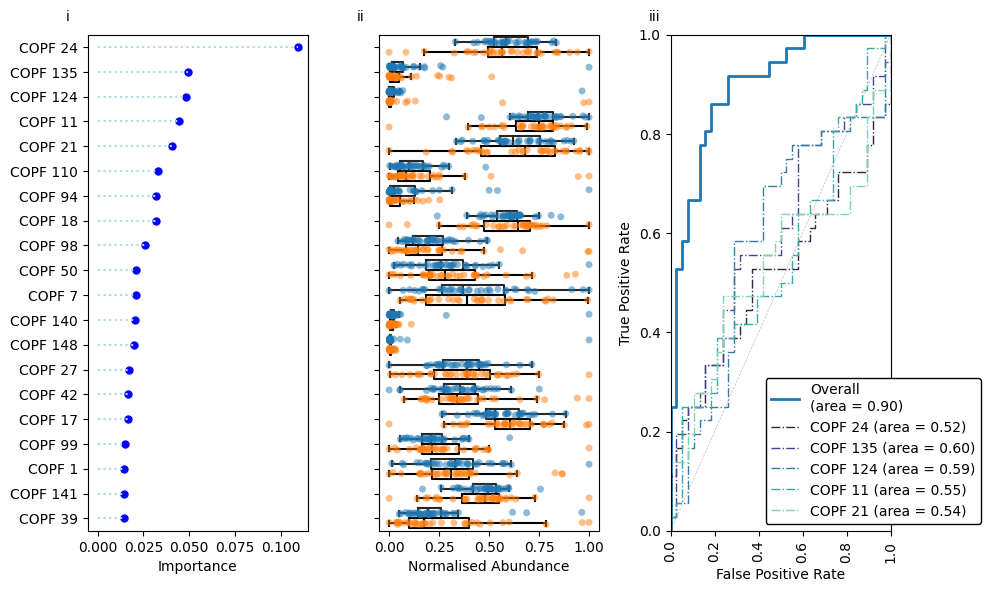

In [18]:
intcol = 'N12M_Pseudomonas aeruginosa'
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

# intcol_title = 'Pseudomonas - next 12 months'
intcol_title = ""
intcol_filename = intcol.replace(" ", "_")

# we limit this to only those samples that ALSO have Pseudomonas, so now we can see if any clusters discriminate regular from MDR Pseudomonas.
merged_df = pc_df.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 0][intcol], how='inner').dropna(subset=intcol)
print(f"We dropped some rows, so our data has shape {merged_df.shape}", file=sys.stderr)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
if categorical_data is None:
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

met=None
if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
fig, axes = cf_analysis_lib.plot_importance_abundance_roc(merged_df, feature_importances_sorted, intcol, intcol_title, model,
                                     custom_labels, plot_legend=False)


labels = [cf_analysis_lib.int2roman(i+1) for i in range(3)] # this makes the labels roman numerals
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, va='top', ha='left')
    ax.set_title("")
print()
plt.tight_layout()
plt.savefig('final_images/fig3c.png')
plt.show()

# Volcano plot for N12M Psuedomonas

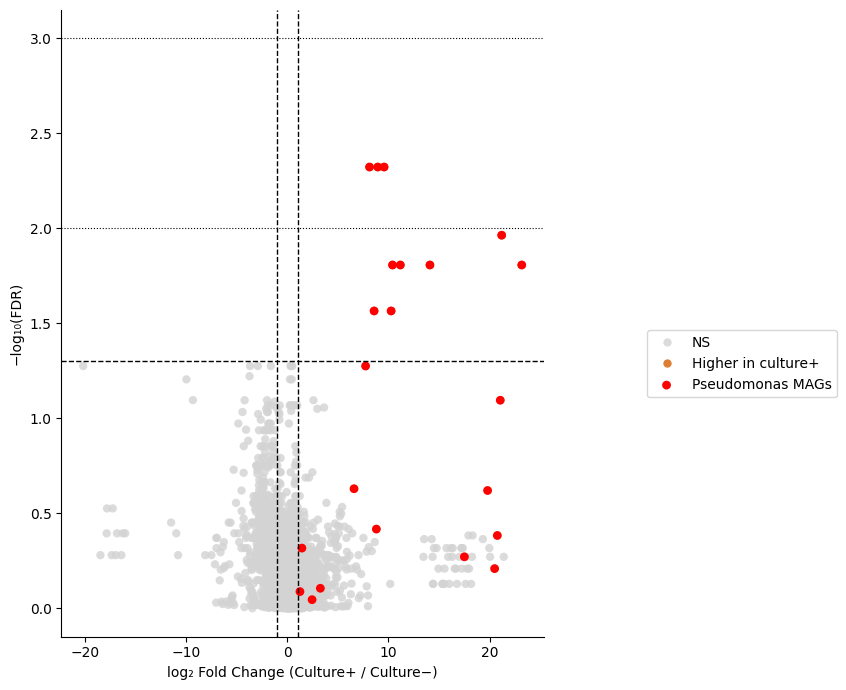

In [19]:
intcol = 'N12M_Pseudomonas aeruginosa'
mag_plus_meta = mags.join(metadata[[intcol]]).dropna(subset=intcol)
mag_cols = mag_plus_meta.columns[:-1]   # all MAGs

results = []
for mag in mags:
    group0 = mag_plus_meta.loc[mag_plus_meta[intcol] == 0, mag]
    group1 = mag_plus_meta.loc[mag_plus_meta[intcol] == 1, mag]

    if len(group0) < 3 or len(group1) < 3:
        continue

    # Avoid divide-by-zero and heavy tails
    fc = (group1.mean() + 1e-6) / (group0.mean() + 1e-6)
    log2_fc = np.log2(fc)

    # Non-parametric test
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    results.append({'MAG': mag, 'log2FC': log2_fc, 'pval': p})

# Create DataFrame
volcano_df = pd.DataFrame(results)

# Adjust p-values using Benjamini-Hochberg
rejected, fdr_pvals = fdrcorrection(volcano_df['pval'])
volcano_df['FDR'] = fdr_pvals
volcano_df['-log10(FDR)'] = -np.log10(volcano_df['FDR'])

# Significance thresholds
fc_thresh = 1.0    # log2 fold-change
fdr_thresh = 0.05  # adjusted p-value
extra_fdr_lines = [0.01, 0.001]

volcano_df['Significance'] = 'NS'
volcano_df.loc[
    (volcano_df['log2FC'] > fc_thresh) & (volcano_df['FDR'] < fdr_thresh),
    'Significance'
] = 'Higher in culture+'
volcano_df.loc[
    (volcano_df['log2FC'] < -fc_thresh) & (volcano_df['FDR'] < fdr_thresh),
    'Significance'
] = 'Higher in culture−'

# add the columns that are pseudomonas from mag_metadata
volcano_df = volcano_df.merge(
    mag_metadata[['MAG', 'pseudomonas']],
    on='MAG',
    how='left'
)
volcano_df['pseudomonas'] = volcano_df['pseudomonas'].fillna(0).astype(bool)

# Sort by significance and take top 10 for labelling
"""
top_hits = (
    volcano_df[volcano_df['FDR'] < fdr_thresh]
    .sort_values('FDR')
    .head(14)
)
"""
# this top hits is limited to the significant ones above the FDR line!
top_hits = volcano_df[(volcano_df['FDR'] < fdr_thresh) & (volcano_df['Significance'] != 'NS') & (volcano_df['-log10(FDR)'] > -np.log10(extra_fdr_lines[1]))]

# --- Plot ---
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=volcano_df,
    x='log2FC',
    y='-log10(FDR)',
    hue='Significance',
    palette={
        'NS': 'lightgrey',
        'Higher in culture+': '#D55E00',
        'Higher in culture−': '#0072B2'
    },
    alpha=0.8,
    edgecolor='none'
)

sns.scatterplot(
    data=volcano_df[volcano_df['pseudomonas']],
    x='log2FC',
    y='-log10(FDR)',
    color='red',
    s=40,
    edgecolor='none',
    label='Pseudomonas MAGs'
)


# Highlight thresholds
plt.axhline(-np.log10(fdr_thresh), color='black', linestyle='--', lw=1)
plt.axvline(fc_thresh, color='black', linestyle='--', lw=1)
plt.axvline(-fc_thresh, color='black', linestyle='--', lw=1)
for f in extra_fdr_lines:
    plt.axhline(-np.log10(f), color='black', ls=':', lw=0.8)
    
# Label top hits
texts = []
for _, r in top_hits.iterrows():
    texts.append(plt.text(
        r['log2FC'],
        r['-log10(FDR)'],
        r['MAG'],
        fontsize=8,
        ha='center',
        va='bottom',
        fontstyle='italic',
        color='black'
    ))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.3))
# Polish
# plt.title('Volcano plot of MAG abundance vs Pseudomonas culture status', fontsize=14, weight='bold')
plt.xlabel('log₂ Fold Change (Culture+ / Culture−)', fontsize=10)
plt.ylabel('−log₁₀(FDR)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='', bbox_to_anchor=(1.2, 0.5), fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()


'N12M_Pseudomonas aeruginosa' has samples from 71 pwCF


Wrote the new image to pseudomonas/img/clusters_manual/N12M_Pseudomonas_aeruginosa_COPF_18.png


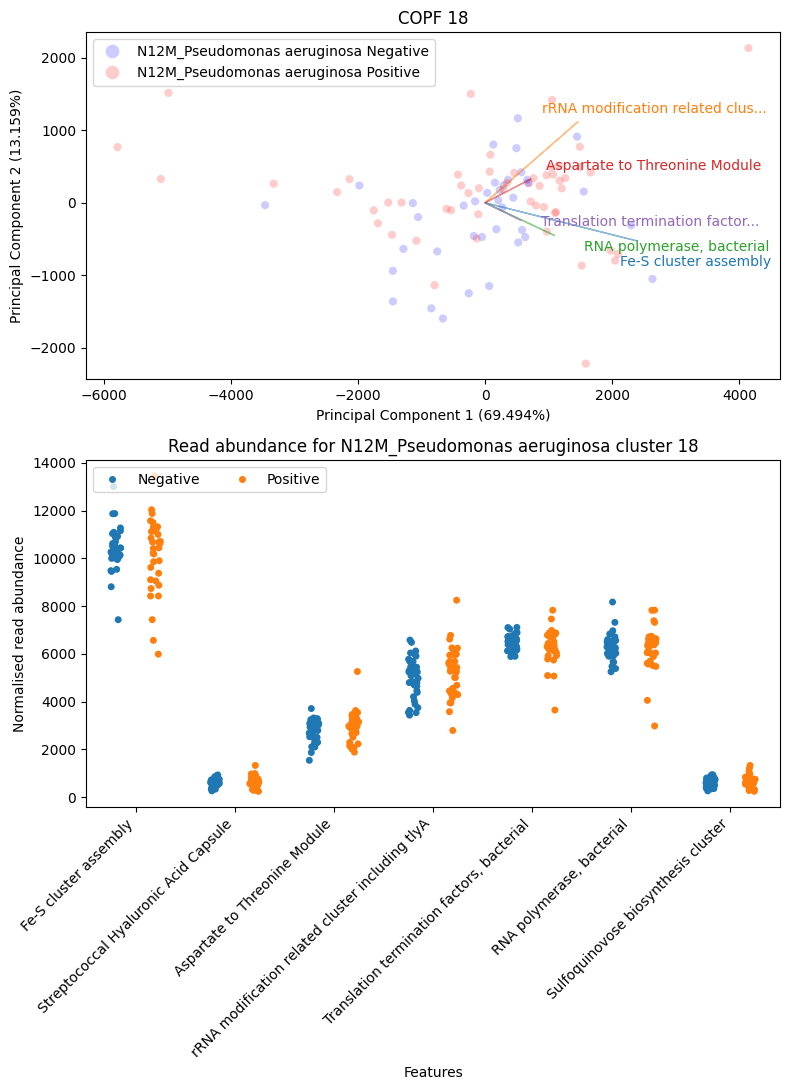

In [20]:
interesting_cluster = 18
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"COPF_{interesting_cluster}"
elif 'COPF' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"COPF_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["COPF"] == int_cluster_num, "Feature"]]
# limit to only those that also have Pseudomonas
merged_df_clust = df_clust.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 0][intcol], how='inner')
df_clust = merged_df_clust.drop(intcol, axis=1)

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

# don't forget to change the legend
intcol_neg = 0

colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')

# Plot the PCA results
fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
ax = axes[0]
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
ax.set_title(f"COPF {interesting_cluster}")
ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)


for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    ax.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    loading_text = top_loadings_df.index[i]
    if len(loading_text) > 30:
        loading_text = loading_text[:30] + "..."
    texts.append(ax.text(xpos, ypos, loading_text, color=c))

adjust_text(texts, ax=ax)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
ax.legend(handles=[blue_patch, red_patch])

## Read abundance
ax = axes[1]

df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]

cl = {'IP': 'red', 'OP': 'blue'}
g = sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)
custom_labels = {0: 'Negative', 1: 'Positive'}
handles, labels = g.get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[float(label)] for label in labels]
g.get_legend().remove()
g.legend(handles, updated_labels, loc='upper left', ncol=2, title=intcol_title)

ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")


plt.tight_layout()
plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
# Show the plot
plt.show()

# Mucoid or not mucoid Pseudomonas

The third Pseudomonas phenotype we'd like to predict is mucoid colony formation, but we don't have lots of data on this as it is dependent on observations by the clinical pathology team.

Note that we have 36 samples that have Pseudomonas, but in 7 of those samples they are neither scored as mucoid or non-mucoid, and in 3 columns they are scored as both mucoid and non-mucoid.

In [21]:
metadata[(metadata['CS_Pseudomonas aeruginosa'] == 1) & (metadata['CS_mucoid'].astype(int) + metadata['CS_non-mucoid'].astype(int) == 0)][['CS_Pseudomonas aeruginosa', 'CS_mucoid', 'CS_non-mucoid']]

,CS_Pseudomonas aeruginosa,CS_mucoid,CS_non-mucoid
NAME,,,
1282052_20180206_S,1,0,0
1447437_20171006_S,1,0,0
1593973_20180427_S,1,0,0
658355_20180321_S,1,0,0
676138_20180323_S,1,0,0
698564_20171001_S,1,0,0
698564_20181205_S,1,0,0


In [22]:
metadata[(metadata['CS_Pseudomonas aeruginosa'] == 1) & (metadata['CS_mucoid'].astype(int) + metadata['CS_non-mucoid'].astype(int) == 2)][['CS_Pseudomonas aeruginosa', 'CS_mucoid', 'CS_non-mucoid']]

,CS_Pseudomonas aeruginosa,CS_mucoid,CS_non-mucoid
NAME,,,
1162967_20180116_S,1,1,1
1465461_20180406_S,1,1,1
1593967_20180424_S,1,1,1


This leaves 26 samples that are _either_ mucoid or non-mucoid.

In [23]:
filtered_md = metadata[(metadata['CS_Pseudomonas aeruginosa'] == 1) & (metadata['CS_mucoid'].astype(int) + metadata['CS_non-mucoid'].astype(int) == 1)]
filtered_md.shape

(26, 166)

'CS_mucoid' has samples from 16 pwCF


We dropped some rows, so our data has shape (26, 151)
The data for the classifier is {'yes': 16, 'no': 10} variables
We used 437 estimators for the random forest classifier
Mean squared error for CS_mucoid using classifier is 0.3333333333333333


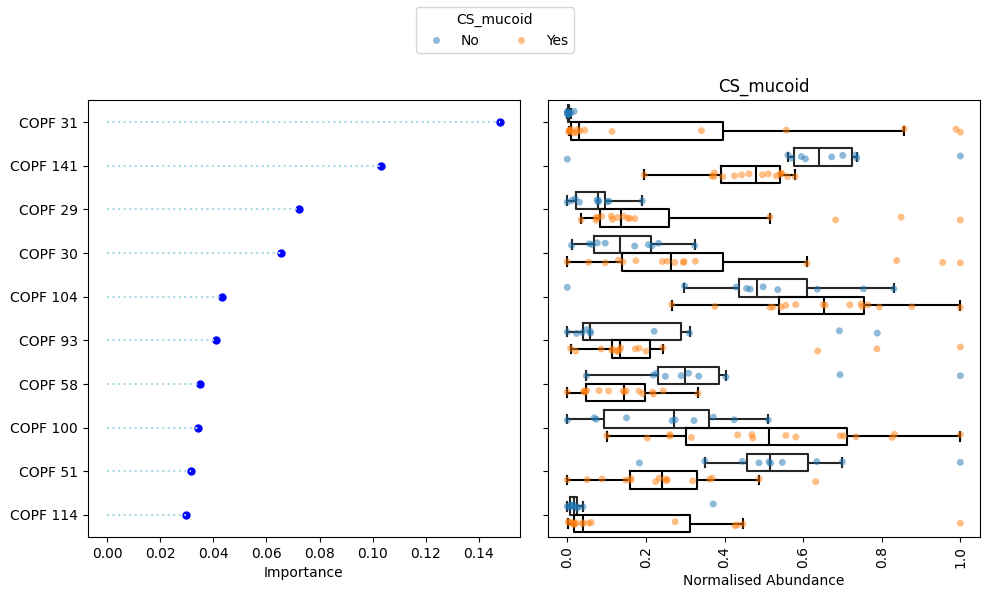

In [24]:
intcol = 'CS_mucoid'
print(f"'{intcol}' has samples from {filtered_md.groupby(intcol).size()[1]} pwCF")

# set up our titles and the filename
intcol_title = replace_index.sub('', intcol)
intcol_filename = intcol.replace(" ", "_")

# we limit this to only those samples that ALSO have Pseudomonas, so now we can see if any clusters discriminate regular from MDR Pseudomonas.
merged_df = pc_df.join(filtered_md[intcol], how='inner').dropna(subset=intcol)
print(f"We dropped some rows, so our data has shape {merged_df.shape}", file=sys.stderr)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
if categorical_data is None:
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

met = None
if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

y_features = 10
topN = list(feature_importances_sorted[:y_features].index) + [intcol]
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)

handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = labels
try:
    updated_labels = [custom_labels[float(label)] for label in labels]
except Exception as e:
    print(f"Couldn't update labels {e}.", file=sys.stderr)

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [25]:
list(cluster_assignments.loc[cluster_assignments["COPF"] == 31, "Feature"])

['Sulfur transfer pathway CsdAEL',
 'Sulfate assimilation related cluster',
 'Stress proteins YciF, YciE',
 'Two partner secretion pathway (TPS)',
 'Type 4 conjugative transfer system, IncI1 type',
 'Type III secretion systems',
 'Siderophore Pyoverdine',
 'Trans-envelope signaling system VreARI in Pseudomonas',
 'L-2-amino-4-methoxy-trans-3-butenoic acid synthesis',
 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas',
 'Extracellular matrix proteins (PSL) involved in mannose-rich biofilm formation in Pseudomonas',
 'IbrA and IbrB: co-activators of prophage gene expression',
 'Rhamnolipids in Pseudomonas',
 'Respiratory Systems - Shewanella (updated)',
 'Phenazine biosynthesis',
 'Periplasmic nitrate reductase EC 1.7.99.4',
 'Outer membrane porins in Pseudomonas and Acinetobacter',
 'Mycobacterial gene cluster associated with resistance against FAS-II antibiotics',
 'Mycobacterial FadE proteins Acyl-CoA dehydrogenase',
 'Mycobacterial FadD p

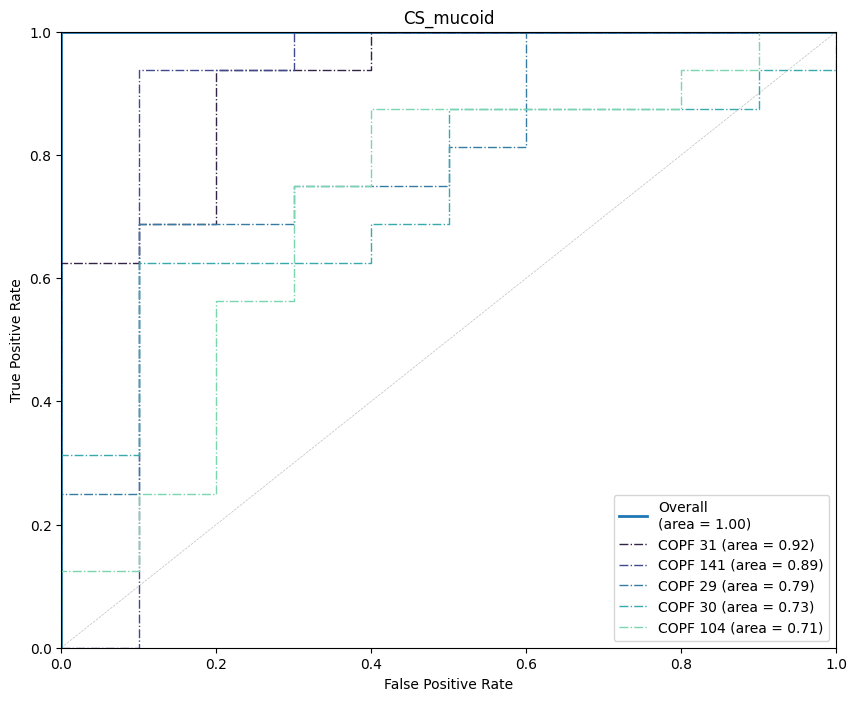

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title, ax=ax)
plt.show()

'CS_mucoid' has samples from 19 pwCF


Wrote the new image to pseudomonas/img/clusters_manual/CS_mucoid_COPF_31.png


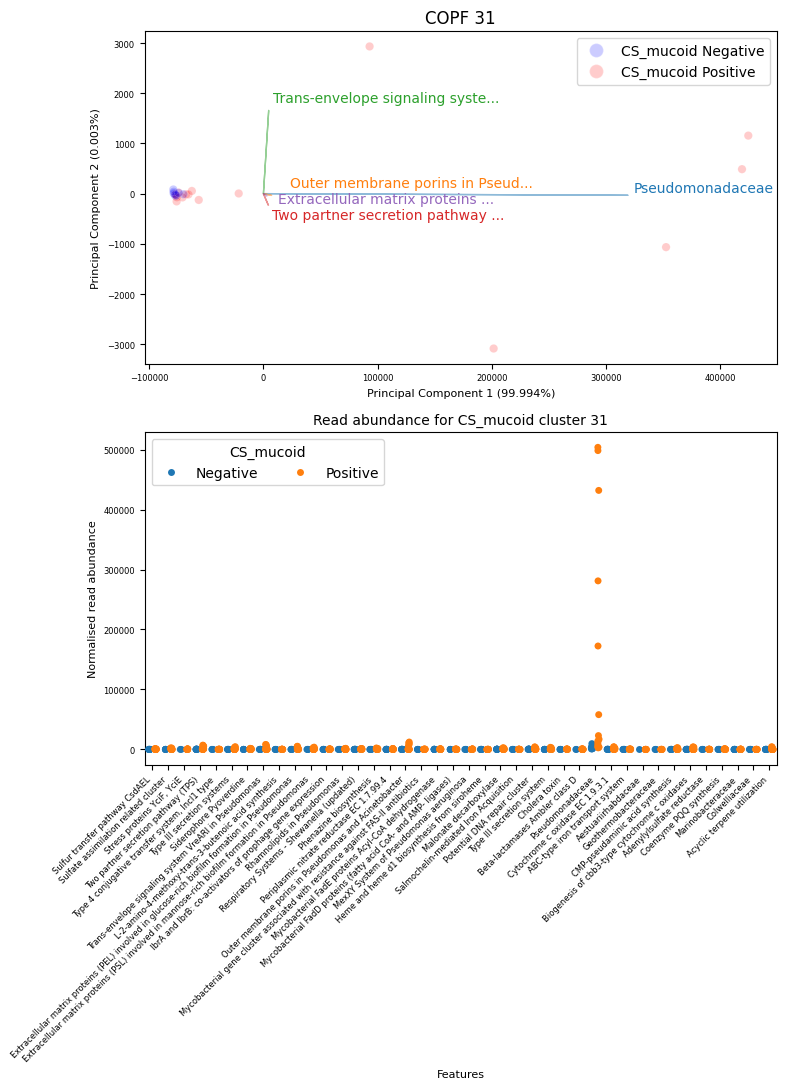

In [27]:
intcol = 'CS_mucoid'
interesting_cluster = 31
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"COPF_{interesting_cluster}"
elif 'COPF' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"COPF_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["COPF"] == int_cluster_num, "Feature"]]
# limit to only those that also have Pseudomonas
merged_df_clust = df_clust.join(filtered_md[intcol], how='inner')
df_clust = merged_df_clust.drop(intcol, axis=1)

if df_clust.shape[1] > 1:
    pca_result = pca.fit_transform(df_clust)
    pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])
    
    # Get loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])
    
    # Create a DataFrame for top loadings
    top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
    top_loadings_df.head()
    
    explained_variance = pca.explained_variance_ratio_ * 100
    pc1_variance = explained_variance[0]
    pc2_variance = explained_variance[1]
    
    # don't forget to change the legend
    intcol_neg = 0
    
    colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')
    
    # Plot the PCA results
    fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
    ax = axes[0]
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
    ax.set_title(f"COPF {interesting_cluster}")
    ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)', fontsize=8)
    ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)', fontsize=8)
    
    # add the loadings ... we only plot maxloadings here
    maxloadings = 5
    if len(loadings) < maxloadings:
        maxloadings = len(loadings)
    
    plotscaler = 2
    texts = []
    colour_cycle = cycle(mcolors.TABLEAU_COLORS)
    
    
    for i in range(maxloadings):
        c = next(colour_cycle)
        xpos = top_loadings_df.iloc[i, 0]*plotscaler
        ypos = top_loadings_df.iloc[i, 1]*plotscaler
        ax.arrow(0, 0, xpos, ypos, 
                  color=c, alpha=0.5, width=0.05)
        loading_text = top_loadings_df.index[i]
        if len(loading_text) > 30:
            loading_text = loading_text[:30] + "..."
        texts.append(ax.text(xpos, ypos, loading_text, color=c))
    
    adjust_text(texts, ax=ax)
    
    # Add a legend
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                             markerfacecolor='blue', alpha=0.2, markersize=10)
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                            markerfacecolor='red', alpha=0.2, markersize=10)
    ax.legend(handles=[blue_patch, red_patch])
    ax.tick_params(axis='both', labelsize=6)
    
    ## Read abundance
    ax = axes[1]
    
    df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
    df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]
    
    cl = {'IP': 'red', 'OP': 'blue'}
    g = sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)
    custom_labels = {0: 'Negative', 1: 'Positive'}
    handles, labels = g.get_legend_handles_labels()  # Get one set of handles and labels
    updated_labels = [custom_labels[float(label)] for label in labels]
    g.get_legend().remove()
    g.legend(handles, updated_labels, loc='upper left', ncol=2, title=intcol_title)


    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
    ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}", fontsize=10)
    ax.tick_params(axis='both', labelsize=6)
    ax.yaxis.label.set_fontsize(8)
    ax.xaxis.label.set_fontsize(8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
    print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
    # Show the plot
    plt.show()
else:
    print(f"df_clust only has one column {df_clust.columns} so we can't run a PCA", file=sys.stderr)
    print(cluster_assignments.loc[cluster_assignments["COPF"] == int_cluster_num], file=sys.stderr)